In [1]:
import pandas as pd
import torch
import numpy as np
import os
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
)
from torch.utils.data import Dataset

In [2]:
# Step 1: Load and Preprocess Data
fake = pd.read_csv("C:/Users/OMEN/Desktop/FakeNews_Best_Model/archive/Fake.csv")
true = pd.read_csv("C:/Users/OMEN/Desktop/FakeNews_Best_Model/archive/True.csv")

In [3]:
# Drop irrelevant columns
fake.drop(['subject', 'date'], axis=1, inplace=True)
true.drop(['subject', 'date'], axis=1, inplace=True)

# Assign labels
fake['label'] = 1  # Fake news
true['label'] = 0  # True news

In [4]:
# Combine and shuffle
data = pd.concat([fake, true], axis=0).sample(frac=1).reset_index(drop=True)
data.fillna(' ', inplace=True)

In [5]:
# Extract raw text and labels
texts = data['text'].tolist()
labels = data['label'].tolist()

In [6]:
# Step 2: Train/Test Split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

In [7]:
# Step 3: Load DistilBERT model - more efficient than standard BERT
model_name = "distilbert-base-uncased"  # Better performance than bert-tiny
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
# Step 4: Tokenize (shorter sequence for speed)
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

class FakeNewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()} | {
            "labels": torch.tensor(self.labels[idx])
        }
    def __len__(self):
        return len(self.labels)

train_dataset = FakeNewsDataset(train_encodings, train_labels)
val_dataset = FakeNewsDataset(val_encodings, val_labels)

In [9]:
# Step 5: Define metrics computation
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [10]:
# Step 6: Training settings
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

c:\Users\OMEN\anaconda3\envs\BERT\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [11]:
# Step 7: Train and evaluate
trainer.train()
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

Epoch,Training Loss,Validation Loss
1,0.000000,0.000021
2,0.000000,0.000012


Evaluation Results: {'eval_loss': 1.2049957149429247e-05, 'eval_runtime': 29.93, 'eval_samples_per_second': 300.034, 'eval_steps_per_second': 18.777, 'epoch': 2.0}


In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=1)
    return {
        'accuracy': accuracy_score(labels, predictions),
        'precision': precision_score(labels, predictions),
        'recall': recall_score(labels, predictions),
        'f1': f1_score(labels, predictions)
    }

In [13]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [14]:
# Get predictions from the trainer
predictions = trainer.predict(val_dataset)

# Compute and display metrics
metrics = compute_metrics((predictions.predictions, predictions.label_ids))
print("Metrics:", metrics)


Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}


In [15]:
# Get predictions from the BERT model
predictions = trainer.predict(val_dataset)
bert_y_pred = predictions.predictions.argmax(axis=1)
bert_y_true = predictions.label_ids

from sklearn.metrics import confusion_matrix

bert_cm = confusion_matrix(bert_y_true, bert_y_pred)

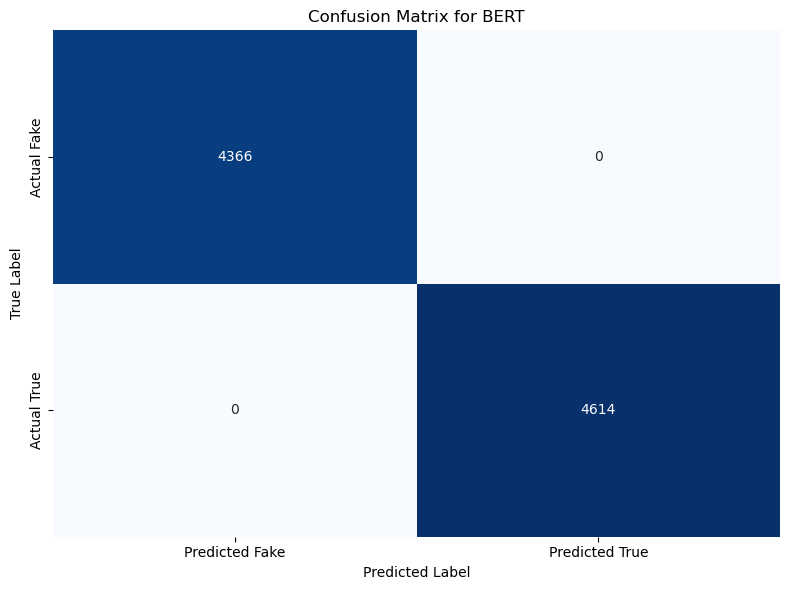

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(bert_cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Fake', 'Predicted True'],
            yticklabels=['Actual Fake', 'Actual True'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label') 
plt.title('Confusion Matrix for BERT')
plt.tight_layout()
plt.show()


In [14]:
# Step 8: Save the model and tokenizer for deployment
model_save_path = "C:/Users/OMEN/Documents/GitHub/BERT_model"
tokenizer.save_pretrained(model_save_path)
trainer.save_model(model_save_path)

In [15]:
# Save training metadata
with open(f"{model_save_path}/model_info.json", "w") as f:
    json.dump({
        "model_name": model_name,
        "max_length": 128,
        "metrics": eval_results,
        "classes": ["True News", "Fake News"]
    }, f)

print(f"Model successfully saved to {model_save_path}")

Model successfully saved to C:/Users/OMEN/Documents/GitHub/BERT_model
